We are testing the performance of different attack parameters below, using the actions and clean observations from the optimal BB attack. Because the ASR was 1 we effectively have a sample and label for every timestep, where the previous action lead to the next clean observation. We can treat this as a supervised learning problem since we effectively have a label for each observation/sample. Unlike the untargeted attack, the actions are not chsen randomly. Given that CityLearn is deterministic we expect that the optinal adversarial trace is also deterministic (confirm with multiple runs) in terms of the action associated with each observation. 

From below: 
- Does the vecorized search work for more than one sample input at the same time (that's how their input for rl, here it gets thousands at a time)
- Increasing the batchsize has a significant effect on speed
- we don't have an init for action 18, does that correspond to the incorrect preds?

This copy used ramdomstate.uniform in mybb

In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_50.zip'
ATTACK = 'myBB'


In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from KBMproject.mybb import BrendelBethgeAttack as BBA

from art.utils import to_categorical

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

Define RL agent

In [3]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [4]:
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss
victim_policy = classifier(
    model=utils.extract_actor(agent),
    loss=CrossEntropyLoss(), 
    nb_classes=agent.action_space[0].n,
    input_shape=agent.observation_space.shape,
    device_type='gpu',
    clip_values = (agent.observation_space.low.min(),agent.observation_space.high.max()) #min and max values of each feature, brendle bethge attack only supports floats values and not array
    )

In [5]:
mask_time = np.ones(agent.observation_space.shape)
mask_time[:6] = 0

In [6]:
samples = pd.read_csv('optimal myBB uninit obs.csv', 
                      dtype='float32')

In [7]:
targets = pd.read_csv('Optimal myBB uninit targets.csv',dtype='float32')

In [8]:
categorical_targets = to_categorical(targets, nb_classes=agent.action_space[0].n)

In [9]:
kwargs = dict(norm=2,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=2000,
        lr=1e-3,
        lr_decay=0.5,
        lr_num_decay=20,
        momentum=0.8,
        binary_search_steps=10,
        init_size=1_500_000, #default 100, finds sample matching the target class through iterative random search
        batch_size=1000,
        )
more_steps_attack = BBA(estimator=victim_policy, **kwargs)

In [12]:
%%time
adv_samples = more_steps_attack.generate(x=samples.to_numpy(), 
                         y=categorical_targets,  
                         mask=mask_time)

CPU times: total: 3h 50min 7s
Wall time: 49min 26s


In [17]:
adv_samples.shape

(8758, 31)

In [13]:
adv_preds = victim_policy.predict(adv_samples)

In [14]:
adv_preds = np.argmax(adv_preds, axis=1)

ASR

In [20]:
np.count_nonzero(adv_preds == np.squeeze(targets))/adv_samples.shape[0]

0.999885818680064

In [21]:
adv_diff = adv_samples - samples

In [22]:
l2_norms = np.linalg.norm(adv_diff, ord=2, axis=1)

In [23]:
linf_norms =  np.linalg.norm(adv_diff, ord=np.inf, axis=1)

In [24]:
df_norms = pd.DataFrame({'L2':l2_norms,'Linf':linf_norms})

<Axes: title={'center': 'KDE of norms for BB Attack'}, ylabel='Density'>

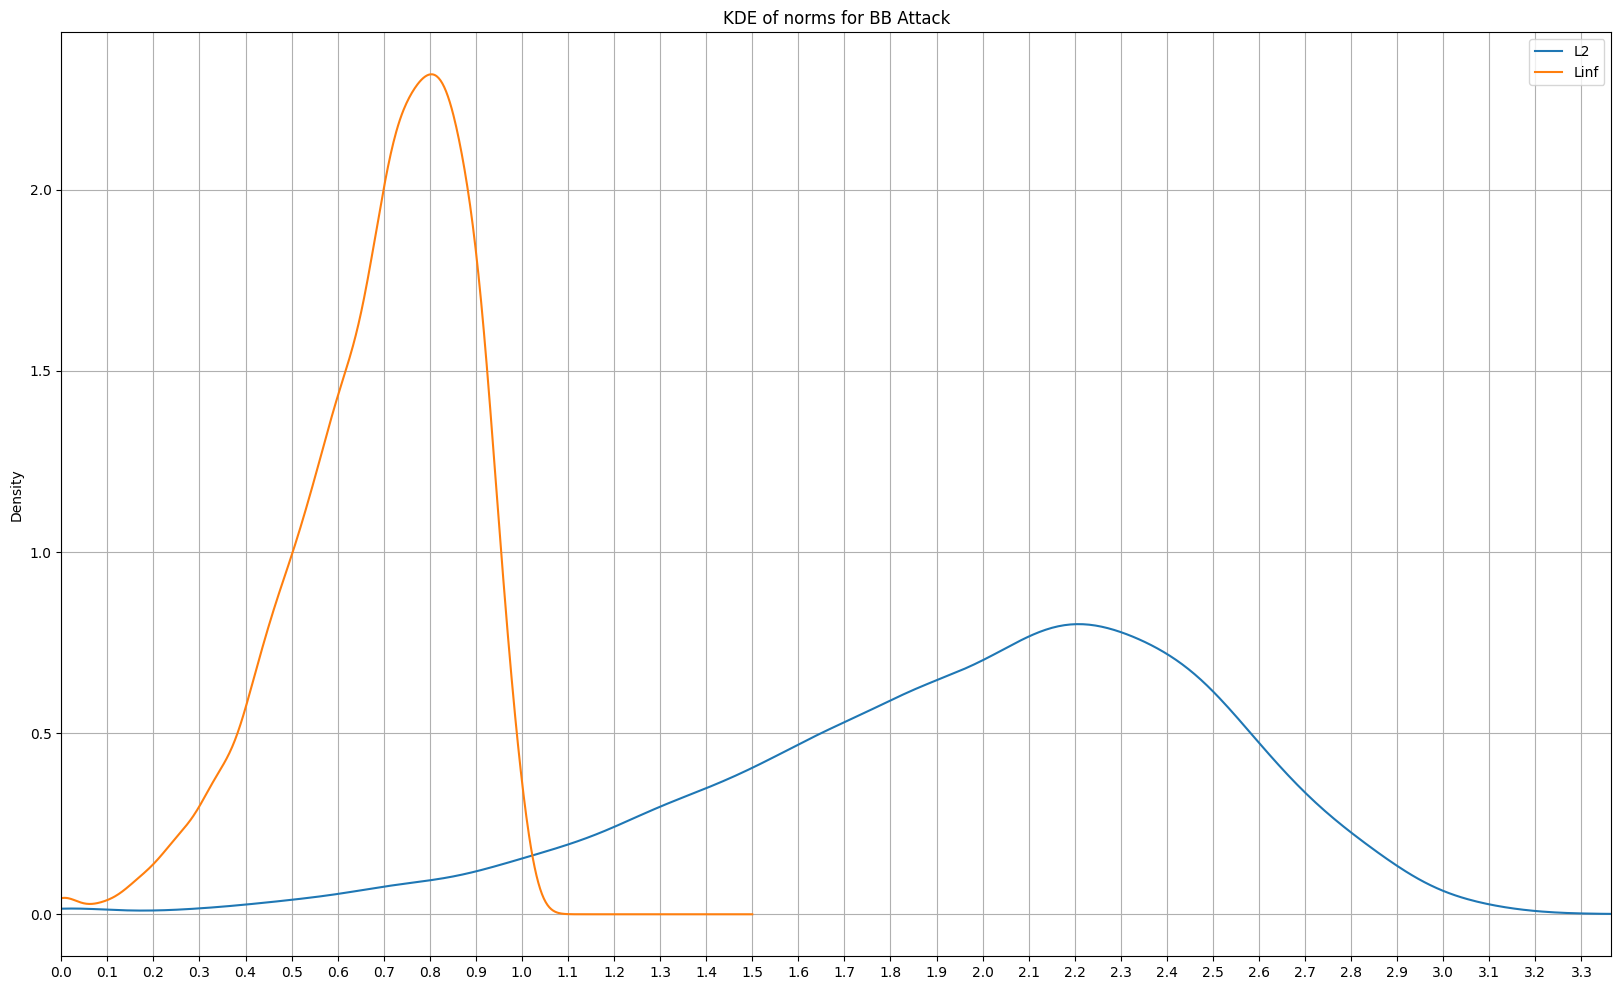

In [25]:
df_norms.plot.kde(grid=True, 
                   xticks=np.arange(start=df_norms.min().min(), stop=df_norms.max().max(), step=0.1),
                   figsize=(20,12),
                   xlim=[df_norms.min().min(),df_norms.max().max()], #NB the max/min of a df is a series, and we need the max/min of the series
                   title='KDE of norms for BB Attack',
                   xlabel='Norms',
                   legend=True
                   )